In [184]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from pre_jiaozheng import BinaryNet,predict_image,pre_result


In [1]:
im_bgr = cv2.imread("./pic_all/25-_rId4_542.png")  # 原始的彩色图像文件，BGR模式
# 定义目标尺寸
target_size = (640, 640)

# 调整图像大小
im_bgr = cv2.resize(im_bgr, target_size)
im_gray = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2GRAY)  # 转灰度图像
im_gray = cv2.GaussianBlur(im_gray, (3, 3), 0)  # 灰度图像滤波降噪
im_edge = cv2.Canny(im_gray, 30, 50)  # 边缘检测获得边缘图像
print(im_gray.shape)

NameError: name 'cv2' is not defined

In [439]:
def find_chessboard(im_edge, im_gray, im_bgr):
    contours, hierarchy = cv2.findContours(im_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = 0
    rect = None

    for item in contours:
        hull = cv2.convexHull(item)
        epsilon = 0.1 * cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, epsilon, True)

        if len(approx) == 4 and cv2.isContourConvex(approx):
            ps = np.reshape(approx, (4, 2))
            ps = ps[np.lexsort((ps[:, 0],))]
            lt, lb = ps[:2][np.lexsort((ps[:2, 1],))]
            rt, rb = ps[2:][np.lexsort((ps[2:, 1],))]

            a = cv2.contourArea(approx)
            if a > area:
                area = a
                rect = (lt, lb, rt, rb)

    if rect is not None:
        pts1 = np.float32([(10, 10), (10, 650), (650, 10), (650, 650)])
        pts2 = np.float32(rect)
        m = cv2.getPerspectiveTransform(pts2, pts1)
        board_gray = cv2.warpPerspective(im_gray, m, (660, 660))
        board_bgr = cv2.warpPerspective(im_bgr, m, (660, 660))
        return board_gray, board_bgr
    else:
        return None

In [440]:
def find_chessboard_no2(im_edge, im_gray, im_bgr):
    contours, hierarchy = cv2.findContours(im_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = 0
    rect = None

    for item in contours:
        hull = cv2.convexHull(item)
        epsilon = 0.1 * cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, epsilon, True)

        if len(approx) == 4 and cv2.isContourConvex(approx):
            ps = np.reshape(approx, (4, 2))
            ps = ps[np.lexsort((ps[:, 0],))]
            lt, lb = ps[:2][np.lexsort((ps[:2, 1],))]
            rt, rb = ps[2:][np.lexsort((ps[2:, 1],))]

            a = cv2.contourArea(approx)
            if a > area:
                area = a
                rect = (lt, lb, rt, rb)

    if rect is not None:
        return im_gray, im_bgr
    else:
        return None

In [441]:

result = find_chessboard(im_edge,im_gray, im_bgr)
if result is not None:
    board_gray, board_bgr = result
    # 在这里可以继续处理透视变换后的图像
else:
    print("未找到棋盘")

#board_gray, board_bgr=im_gray,im_bgr

In [442]:
def visualize_images(original, transformed_gray, transformed_color):
    plt.figure(figsize=(12, 6))

    # 显示原始彩色图像
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # 显示透视变换后的灰度图像
    plt.subplot(1, 3, 2)
    plt.imshow(transformed_gray, cmap='gray')
    plt.title('Perspective Transformed Gray Chessboard')
    plt.axis('off')

    # 显示透视变换后的彩色图像
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(transformed_color, cv2.COLOR_BGR2RGB))
    plt.title('Perspective Transformed Color Chessboard')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

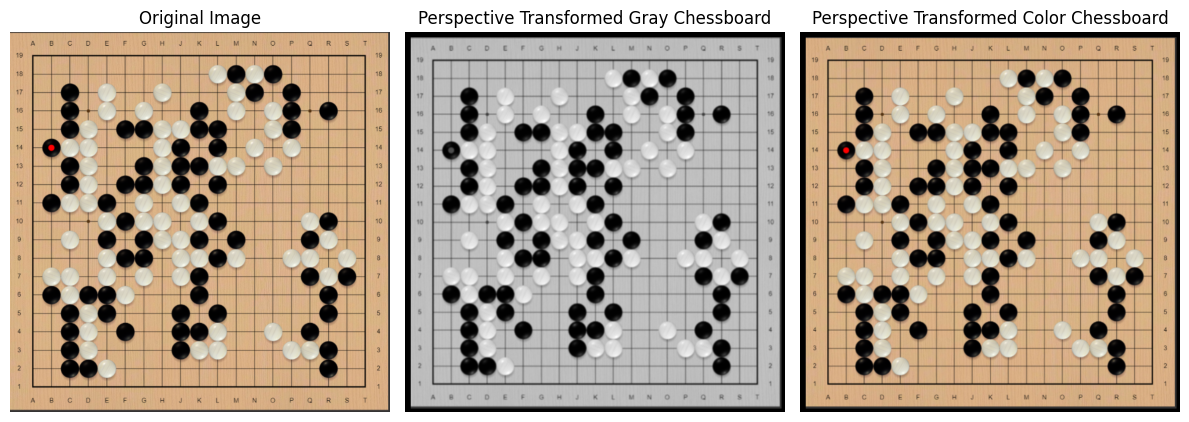

In [443]:
visualize_images(im_bgr, board_gray, board_bgr)

In [444]:
def location_grid(board_gray, board_bgr):
    circles = cv2.HoughCircles(board_gray, cv2.HOUGH_GRADIENT, 1, 20, param1=90, param2=16, minRadius=10,
                               maxRadius=20)# 圆检测
    print(type(circles))
    if circles is None:
        return None
    else:
        if circles.shape[1]>10:
            xs, ys = circles[0, :, 0], circles[0, :, 1] # 所有棋子的x坐标和y坐标
            xs.sort()
            ys.sort()

            k = 1
            while xs[k] - xs[:k].mean() < 15:
                k += 1
            x_min = int(round(xs[:k].mean()))

            k = 1
            while ys[k] - ys[:k].mean() < 15:
                k += 1
            y_min = int(round(ys[:k].mean()))

            k = -1
            while xs[k:].mean() - xs[k - 1] < 15:
                k -= 1
            x_max = int(round(xs[k:].mean()))

            k = -1
            while ys[k:].mean() - ys[k - 1] < 15:
                k -= 1
            y_max = int(round(ys[k:].mean()))

            if abs(600 - (x_max - x_min)) < abs(600 - (y_max - y_min)):
                v_min, v_max = x_min, x_max
            else:
                v_min, v_max = y_min, y_max

            margin = 45  # 这个值是用来定义变换后图像中保留的边界区域的大小。通过调整这个值，你可以控制变换后图像中保留的周围信息的数量。较大的margin值将保留更多的周围信息，较小的值将减少保留的周围信息
            pts1 = np.float32([[margin, margin], [margin, 600 - margin], [600 - margin, margin], [600 - margin, 600 - margin]])
            pts2 = np.float32([(v_min, v_min), (v_min, v_max), (v_max, v_min), (v_max, v_max)])
            # pts1 是变换后图像中的四个角点的坐标，pts2 是原始图像中对应的四个圆心位置。这些点将用于计算透视变换矩阵。

            m = cv2.getPerspectiveTransform(pts2, pts1)
            board_gray = cv2.warpPerspective(board_gray, m, (620, 620))
            board_bgr = cv2.warpPerspective(board_bgr, m, (620, 620))

            return board_gray, board_bgr


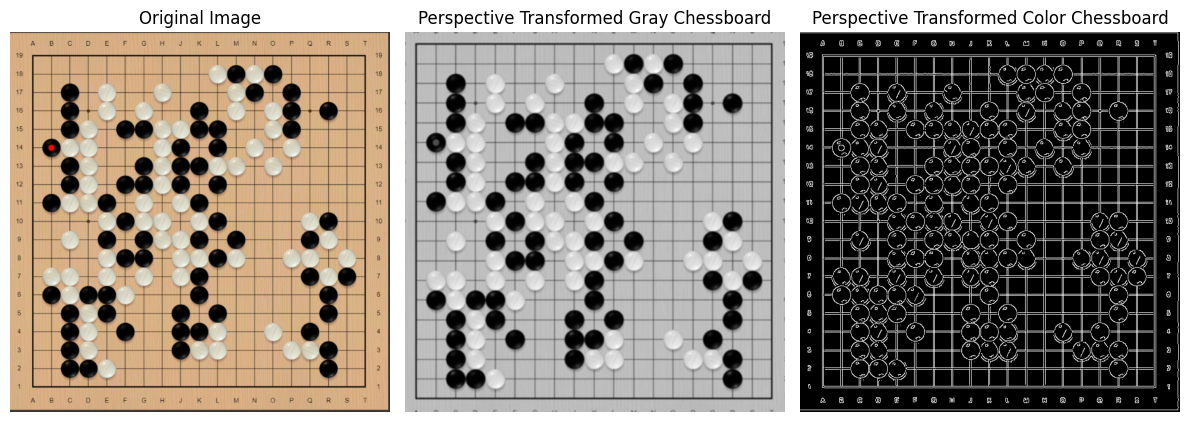

In [445]:
def center_crop_image(image, target_size):
    # 获取图像尺寸
    height, width = image.shape[:2]

    # 定义中心裁剪的尺寸
    crop_size = min(height, width, target_size)

    # 计算裁剪区域的左上角坐标
    crop_left = (width - crop_size) // 2
    crop_top = (height - crop_size) // 2

    # 进行中心裁剪
    center_cropped_image = image[crop_top:crop_top+crop_size, crop_left:crop_left+crop_size]

    return center_cropped_image

visualize_images(im_bgr,center_crop_image(im_gray,598),im_edge)

<class 'numpy.ndarray'>


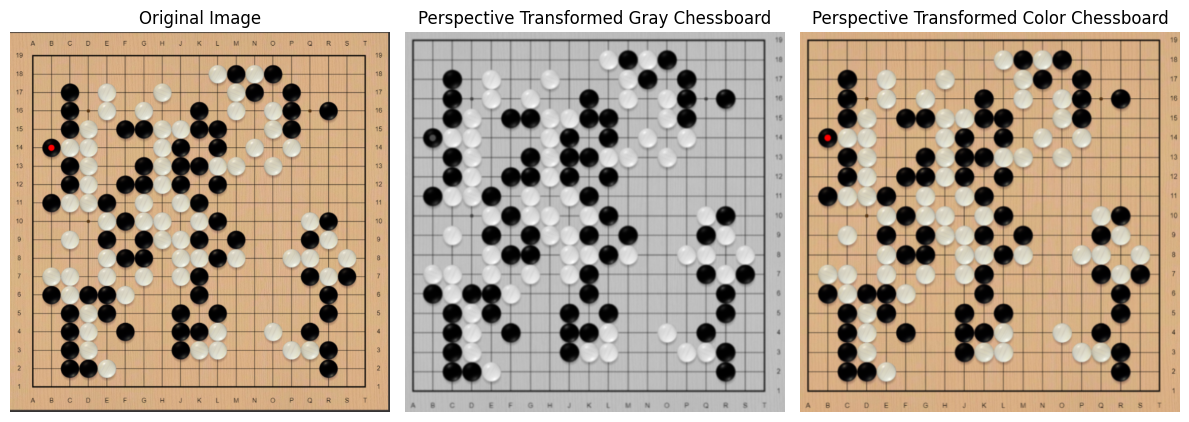

In [446]:
result = find_chessboard(im_edge, im_gray, im_bgr)
board_gray, board_bgr = result
# 调用函数
result = location_grid(board_gray, board_bgr)
if result is not None:
    transformed_gray, transformed_bgr = result

    # 在这里可以继续处理透视变换后的图像
        # 调用可视化函数
    #visualize_images(im_bgr, transformed_gray, transformed_bgr)
else:
    result = find_chessboard_no2(im_edge, im_gray, im_bgr)
    board_gray, board_bgr = result
    result = location_grid(board_gray, board_bgr)
    transformed_gray, transformed_bgr = result
visualize_images(im_bgr,transformed_gray,transformed_bgr)

In [447]:
def identify_chessman(board_gray, board_bgr):
    if board_gray is None:
        return None

    mesh = np.linspace(22, 598, 19, dtype=np.int_)
    rows, cols = np.meshgrid(mesh, mesh)

    circles = cv2.HoughCircles(board_gray, cv2.HOUGH_GRADIENT, 1, 20, param1=90, param2=10, minRadius=12,
                               maxRadius=18)
    circles = np.uint32(np.around(circles[0]))

    phase = np.zeros_like(rows, dtype=np.uint8)
    im_hsv = cv2.cvtColor(board_bgr, cv2.COLOR_BGR2HSV_FULL)

    for circle in circles:
        # 偏移量调整（例如，增加一些偏移量来调整圆的检测区域）
        offset_row = 0  # 行偏移量
        offset_col = 0  # 列偏移量

        row = int(round((circle[1] - 22) / 32)) + offset_row
        col = int(round((circle[0] - 22) / 32)) + offset_col

        hsv_ = im_hsv[cols[row, col] - 5:cols[row, col] + 5, rows[row, col] - 5:rows[row, col] + 5]
        s = np.mean(hsv_[:, :, 1])
        v = np.mean(hsv_[:, :, 2])

        if 0 < v < 115:
            phase[row, col] = 1  # 黑棋
        elif 0 < s < 50 and 114 < v < 256:
            phase[row, col] = 2  # 白棋

    return phase

In [448]:
# 调用函数
# 调用函数
chessman_array = identify_chessman(transformed_gray, transformed_bgr)

if chessman_array is not None:
    # 在这里可以继续处理生成的棋盘状态数组
    print(chessman_array)
else:
    print("未找到棋盘")

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 1 2 1 0 0 0 0 0]
 [0 0 1 0 2 0 0 2 0 0 0 2 1 0 1 0 0 0 0]
 [0 0 1 0 2 0 2 0 0 1 0 2 0 2 1 0 1 0 0]
 [0 0 1 2 0 1 1 2 2 1 1 0 0 2 1 0 0 0 0]
 [0 1 2 2 0 0 0 2 1 0 1 0 2 0 2 0 0 0 0]
 [0 0 1 2 0 0 1 2 1 1 2 2 0 2 0 0 0 0 0]
 [0 0 1 2 0 1 1 2 1 0 1 0 0 0 0 0 0 0 0]
 [0 1 2 2 1 0 2 0 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 1 2 2 0 2 1 0 0 0 0 0 1 0 0]
 [0 0 2 0 1 0 1 2 2 1 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 2 1 1 0 2 2 1 2 0 0 2 0 0 0 0]
 [0 2 2 0 2 0 2 0 2 1 0 0 0 0 0 1 0 1 0]
 [0 1 2 1 1 2 0 0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 1 2 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0]
 [0 0 1 2 0 1 0 0 1 1 2 0 0 0 0 1 0 0 0]
 [0 0 1 2 0 0 0 0 1 2 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [128]:
# 构建目标文件夹路径
target_folder = "./pic_data/yes"
image_paths = [os.path.join(target_folder, filename) for filename in os.listdir(target_folder)]
# 打印图片路径
for path in image_paths:
    print(path)

./pic_data/yes\1-1_rId4_0.png
./pic_data/yes\1-2_rId4_1.png
./pic_data/yes\10-_rId4_2.png
./pic_data/yes\10-_rId4_3.png
./pic_data/yes\10-_rId4_4.png
./pic_data/yes\11-_rId4_5.png
./pic_data/yes\11-_rId4_6.png
./pic_data/yes\12-_rId4_7.png
./pic_data/yes\12-_rId4_8.png
./pic_data/yes\12-_rId4_9.png
./pic_data/yes\13-_rId4_10.png
./pic_data/yes\13-_rId4_11.png
./pic_data/yes\13-_rId4_12.png
./pic_data/yes\13-_rId4_13.png
./pic_data/yes\13-_rId4_14.png
./pic_data/yes\14-_rId4_15.png
./pic_data/yes\14-_rId4_16.png
./pic_data/yes\14-_rId4_17.png
./pic_data/yes\14-_rId4_18.png
./pic_data/yes\15-_rId4_19.png
./pic_data/yes\15-_rId4_20.png
./pic_data/yes\15-_rId4_21.png
./pic_data/yes\16-_rId4_22.png
./pic_data/yes\16-_rId4_23.png
./pic_data/yes\16-_rId4_24.png
./pic_data/yes\16-_rId4_25.png
./pic_data/yes\17-_rId4_26.png
./pic_data/yes\17-_rId4_27.png
./pic_data/yes\17-_rId4_28.png
./pic_data/yes\18-_rId4_29.png
./pic_data/yes\18-_rId4_30.png
./pic_data/yes\18-_rId4_31.png
./pic_data/yes\18-